In [1]:
try:
    initialized
except NameError:
    ## Matplotlib configuration
    %matplotlib inline
    initialized = True

from sklearn.linear_model import LinearRegression, RidgeCV
from lib import Model, Humanizer, Plotter
from lib.hbsort import DataFrameBuilder, ExperimentInfo
from mynotebook import *

In [200]:
# load all profiling and target with workers, input size and time
exp_info = ExperimentInfo(threads=2, block_size=128 * 1024**2)
df_builder = DataFrameBuilder(threads=exp_info.threads)
prof_out = df_builder.get_profiling()
target1_out = df_builder.get_target(0)
target2_out = df_builder.get_target(1)

humanizer = Humanizer(size=Humanizer.SIZE_MIB)
prof = process_outliers(prof_out, humanizer)
humanizer = Humanizer(size=Humanizer.SIZE_GIB)
target1 = process_outliers(target1_out, humanizer)
target2 = process_outliers(target2_out, humanizer)

,input size (MiB),workers,outliers,samples,available
0,263,1,1,10,9
1,263,2,1,10,9
2,526,1,2,10,8
3,526,2,0,10,10
4,526,4,1,10,9
5,1051,1,2,10,8
6,1051,2,3,10,7
7,1051,4,0,10,10
8,1051,8,0,10,10
9,2102,2,1,10,9


,input size (GiB),workers,outliers,samples,available
0,3,1,0,10,10
1,3,2,1,10,9
2,3,4,1,10,9
3,3,8,1,10,9
4,3,12,0,10,10
5,3,16,0,10,10


,input size (GiB),workers,outliers,samples,available
0,31,16,1,10,9
1,31,32,1,10,9
2,31,64,2,10,8
3,31,123,1,10,9
4,31,128,0,10,10


In [817]:
import numpy as np


def get_iterations_by_blocks(inputs, threads, block_size):
    tasks = np.ceil(inputs / block_size)
    first = (tasks > 0).astype('int')
    #nonfirst = np.ceil((tasks - threads) / threads).astype('int')
    nonfirst = (tasks - threads) / threads
    nonfirst[nonfirst < 0] = 0
    return first, nonfirst

def get_iterations_by_n_tasks(threads, tasks):
    first = [1] * len(threads)
    #nonfirst = np.ceil((tasks - threads) / threads).astype('int')
    nonfirst = (tasks - threads) / threads
    nonfirst[nonfirst < 0] = 0
    return first, nonfirst

def get_extra_df(df, exp_info):
    extra = pd.DataFrame()
    extra['workers'] = df.workers
    threads = df.workers * exp_info.threads
    _, extra['iters_stg0_nf'] = get_iterations_by_blocks(df.input,
                                                                             threads,
                                                                             exp_info.block_size)
    _, extra['iters_stg1_nf'] = get_iterations_by_n_tasks(threads, 200)
    extra['ms'] = df.ms
    return extra
    
    extra = pd.DataFrame()
    extra['workers'] = df.workers
    extra['input'] = df.input
    threads = df.workers * exp_info.threads
    extra['iters_stg0_f'], extra['iters_stg0_nf'] = get_iterations_by_blocks(df.input,
                                                                             threads,
                                                                             exp_info.block_size)
    extra['iters_stg1_f'], extra['iters_stg1_nf'] = get_iterations_by_n_tasks(threads, 200)
    extra['sqrt_iters_stg0_nf'] = np.sqrt(extra['iters_stg0_nf'])
    select = extra['iters_stg1_nf'] > 0
    col = 'input_per_iter_stg1_nf'
    extra.loc[select, col] = df[select].input / (extra[select]['iters_stg1_nf'] + extra[select]['iters_stg1_f']) # reduce task size
    extra.loc[~select, col] = 0
    select = extra['iters_stg0_nf'] > 0
    col = 'input_per_iter_stg0_nf'
    extra.loc[select, col] = df[select].input / (extra[select]['iters_stg0_nf'] + extra[select]['iters_stg0_f'])
    extra.loc[~select, col] = 0
    extra.drop('iters_stg0_f', axis=1, inplace=True)
    extra.drop('iters_stg1_f', axis=1, inplace=True)
    extra['ms'] = df.ms

    #extra['workers2'] = df.workers ** 2
    #extra['log_workers'] = np.log2(df.workers)
    #extra['log_input'] = np.log2(df.input)
    #extra['input_per_worker'] = df.input / df.workers
    #extra['log_input_per_worker'] = np.log2(df.input / df.workers)
    #extra['sqrt_iters_stg1_nf'] = np.sqrt(extra['iters_stg1_nf'])
    #extra['iters_stg0_nf_x_w'] = extra['iters_stg0_nf'] * df.workers
    #extra['iters_stg1_nf_x_w'] = extra['iters_stg1_nf'] * df.workers
    #extra['iters_stg0_nf_x_lw'] = extra['iters_stg0_nf'] * np.log2(df.workers)
    #extra['iters_stg1_nf_x_lw'] = extra['iters_stg1_nf'] * np.log2(df.workers)
    #extra['a'] = extra['iters_stg0_nf'] * extra['workers']
    #extra['b'] = extra['iters_stg1_nf'] * extra['workers']
    #extra['c'] = extra['iters_stg0_nf'] * extra['iters_stg1_nf']
    #extra['d'] = df.input * df.workers

    #extra['input'] /= 128 * 1024**2
    #extra['iters_stg0_nf_2'] = extra['iters_stg0_nf'] ** 2
    #extra['iters_stg1_nf_2'] = extra['iters_stg1_nf'] ** 2
    
    return extra

,workers,iters_stg0_nf,iters_stg1_nf,ms
0,2,5.25,49.00,133991.56
1,4,2.12,24.00,87356.44
2,8,0.56,11.50,61925.00
3,16,0.00,5.25,47477.70
4,16,6.66,5.25,328359.22
5,32,2.83,2.12,284544.11
6,128,0.00,0.00,174298.40


,workers,iters_stg0_nf,iters_stg1_nf,ms
10,2,5.25,49.0,135677


,workers,iters_stg0_nf,iters_stg1_nf,ms
180,16,6.66,5.25,324576


[0.14731421810628348,
 (2, 0.030615453296159688),
 (4, 0.007893067827503215),
 (8, 0.0904865390428037),
 (16, 0.30893383147341713),
 (32, 0.23143254805984795),
 (128, 0.052904255570835564)]

[0.1588707608518695,
 (2, 0.030450947660484326),
 (4, 0.02463531168866663),
 (8, 0.09305779892287358),
 (16, 0.3255065024804362),
 (32, 0.230666368013604),
 (128, 0.07326820716725713)]

78019.817339377274

array([   824.2164825 ,  43115.15163879,  -3594.56026661])

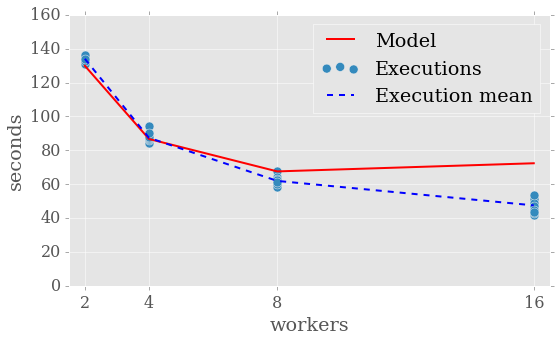

[0.1800981776471546,
 (2, 0.030450947660484326),
 (4, 0.02463531168866663),
 (8, 0.09305779892287358),
 (16, 0.53303360484965)]

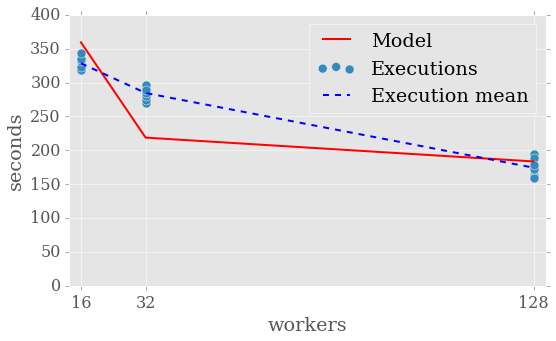

[0.130820245800957,
 (16, 0.09492083318130987),
 (32, 0.230666368013604),
 (128, 0.07326820716725713)]

In [818]:
# Make regressions on total application time
_target1 = target1[(target1.workers != 12) & (target1.workers != 1)]
_target2 = target2[(target2.workers != 123) & (target2.workers != 64)]
_prof = pd.concat([_target1, _target2])
#_prof = prof#[prof.workers < 8]
_prof = _prof.groupby(['workers', 'input']).mean().reset_index()

_prof = get_extra_df(_prof, exp_info)
_target1 = get_extra_df(_target1, exp_info)
_target2 = get_extra_df(_target2, exp_info)

display(_prof)
display(_target1.head(1))
display(_target2.head(1))
model = Model(LinearRegression())
model.fit(_prof)
linear = model.get_linreg()
display(model.score(_prof))
display(model.score(pd.concat([_target1, _target2])))
display(linear.intercept_, linear.coef_)

#plotter = Plotter()
#sizes = _prof['input']
#for size in sizes.unique():
#    prof_size = _prof[sizes == size]
#    plotter.plot_model(model, prof_size)
#    display('{:d}: {}'.format( np.round(size / 1024 ** 2).astype('int'), model.score(prof_size)[0]))

plotter = Plotter((1.5, 16.5))
plotter.plot_model(model, _target1)
display(model.score(_target1))

plotter = Plotter((13, 131))
plotter.plot_model(model, _target2)
display(model.score(_target2))

In [819]:
coefs = model.get_linreg().coef_
cols = _prof.columns
val_var = [(coef, col) for coef, col in zip(coefs, cols)]
for value, var in sorted(val_var, key=lambda x: x[0]):
    print('{:f} {}'.format(value, var))

-3594.560267 iters_stg1_nf
824.216482 workers
43115.151639 iters_stg0_nf
